# Alternative Tracing Methods

We've covered the @traceable decorator for tracing setup. This lesson explores alternative tracing methods and when to use each approach.  
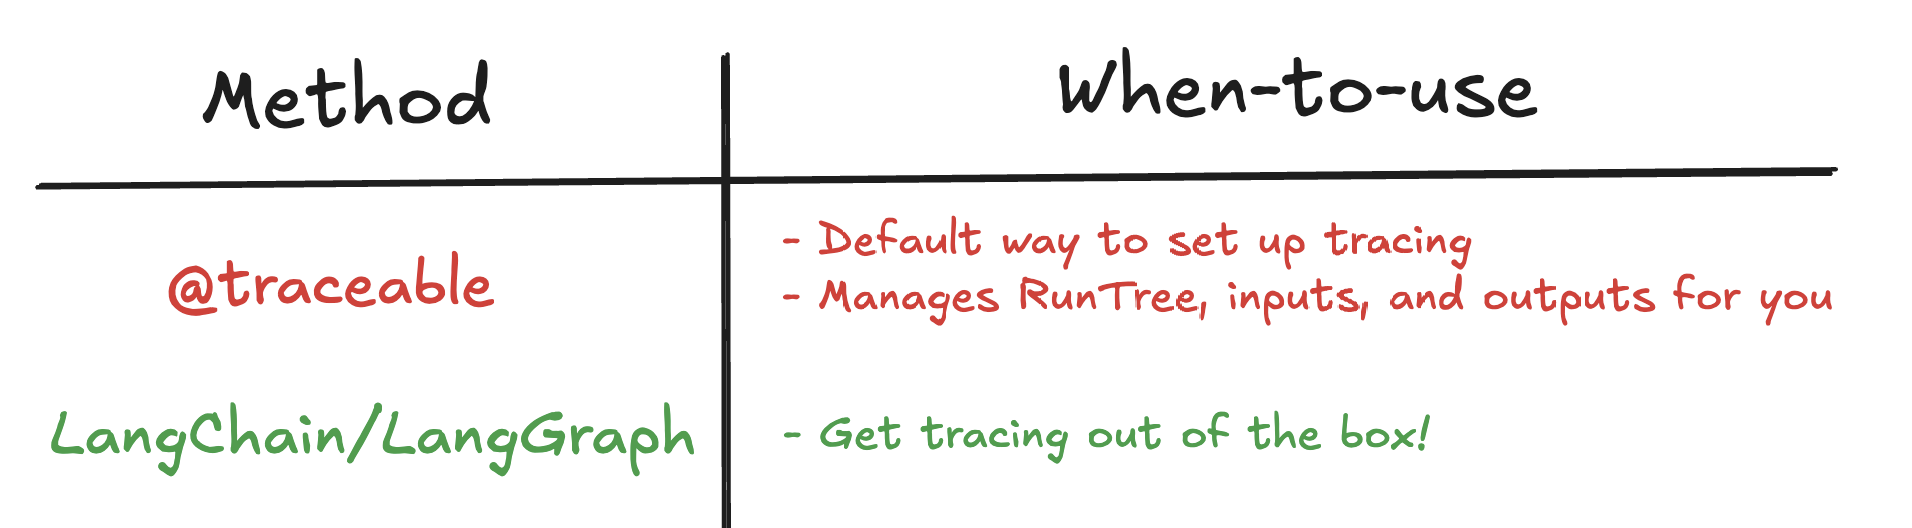

## LangChain and LangGraph
Setting up

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

USER_AGENT environment variable not set, consider setting it to identify your requests.


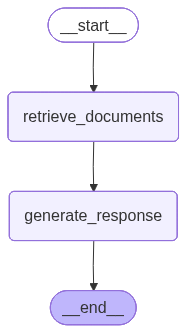

In [2]:
import nest_asyncio
import operator
from langchain.schema import Document
from langchain_core.messages import HumanMessage, AnyMessage, get_buffer_string
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from typing import List
from typing_extensions import TypedDict, Annotated
from utils import get_vector_db_retriever, RAG_PROMPT

nest_asyncio.apply()

retriever = get_vector_db_retriever()
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

# Define Graph state
class GraphState(TypedDict):
    question: str
    messages: Annotated[List[AnyMessage], operator.add]
    documents: List[Document]

# Define Nodes
def retrieve_documents(state: GraphState):
    messages = state.get("messages", [])
    question = state["question"]
    documents = retriever.invoke(f"{get_buffer_string(messages)} {question}")
    return {"documents": documents}

def generate_response(state: GraphState):
    question = state["question"]
    messages = state["messages"]
    documents = state["documents"]
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    
    rag_prompt_formatted = RAG_PROMPT.format(context=formatted_docs, conversation=messages, question=question)
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    return {"documents": documents, "messages": [HumanMessage(question), generation]}

# Define Graph
graph_builder = StateGraph(GraphState)
graph_builder.add_node("retrieve_documents", retrieve_documents)
graph_builder.add_node("generate_response", generate_response)
graph_builder.add_edge(START, "retrieve_documents")
graph_builder.add_edge("retrieve_documents", "generate_response")
graph_builder.add_edge("generate_response", END)

simple_rag_graph = graph_builder.compile()
display(Image(simple_rag_graph.get_graph().draw_mermaid_png()))

This example uses LangGraph to build a simple graph.
You can pass metadata or other fields via an optional config parameter.


In [3]:
question = "How do LangChain and LangGraph make using LagSmith easier and more feasible?"
simple_rag_graph.invoke({"question": question}, config={"metadata": {"foo": "bar"}})

{'question': 'How do LangChain and LangGraph make using LagSmith easier and more feasible?',
 'messages': [HumanMessage(content='How do LangChain and LangGraph make using LagSmith easier and more feasible?', additional_kwargs={}, response_metadata={}),
  AIMessage(content="LangSmith is framework agnostic, meaning it can be used with or without LangChain and LangGraph, which allows for flexibility in application development. However, using LangChain's open-source frameworks can enhance the integration and functionality of LangSmith, making it easier to build and manage LLM applications. This combination can streamline processes like observability and evaluation, ultimately improving the development experience.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 76, 'prompt_tokens': 1574, 'total_tokens': 1650, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}

### Tracing Context Manager
Python's trace context manager logs traces to LangSmith. Use when you need:

* Tracing specific code blocks
* Control over inputs/outputs/attributes
* Alternatives to decorators/wrappers

Works seamlessly with @traceable and wrap_openai.

You still need to set your LANGSMITH_API_KEY and LANGSMITH_TRACING

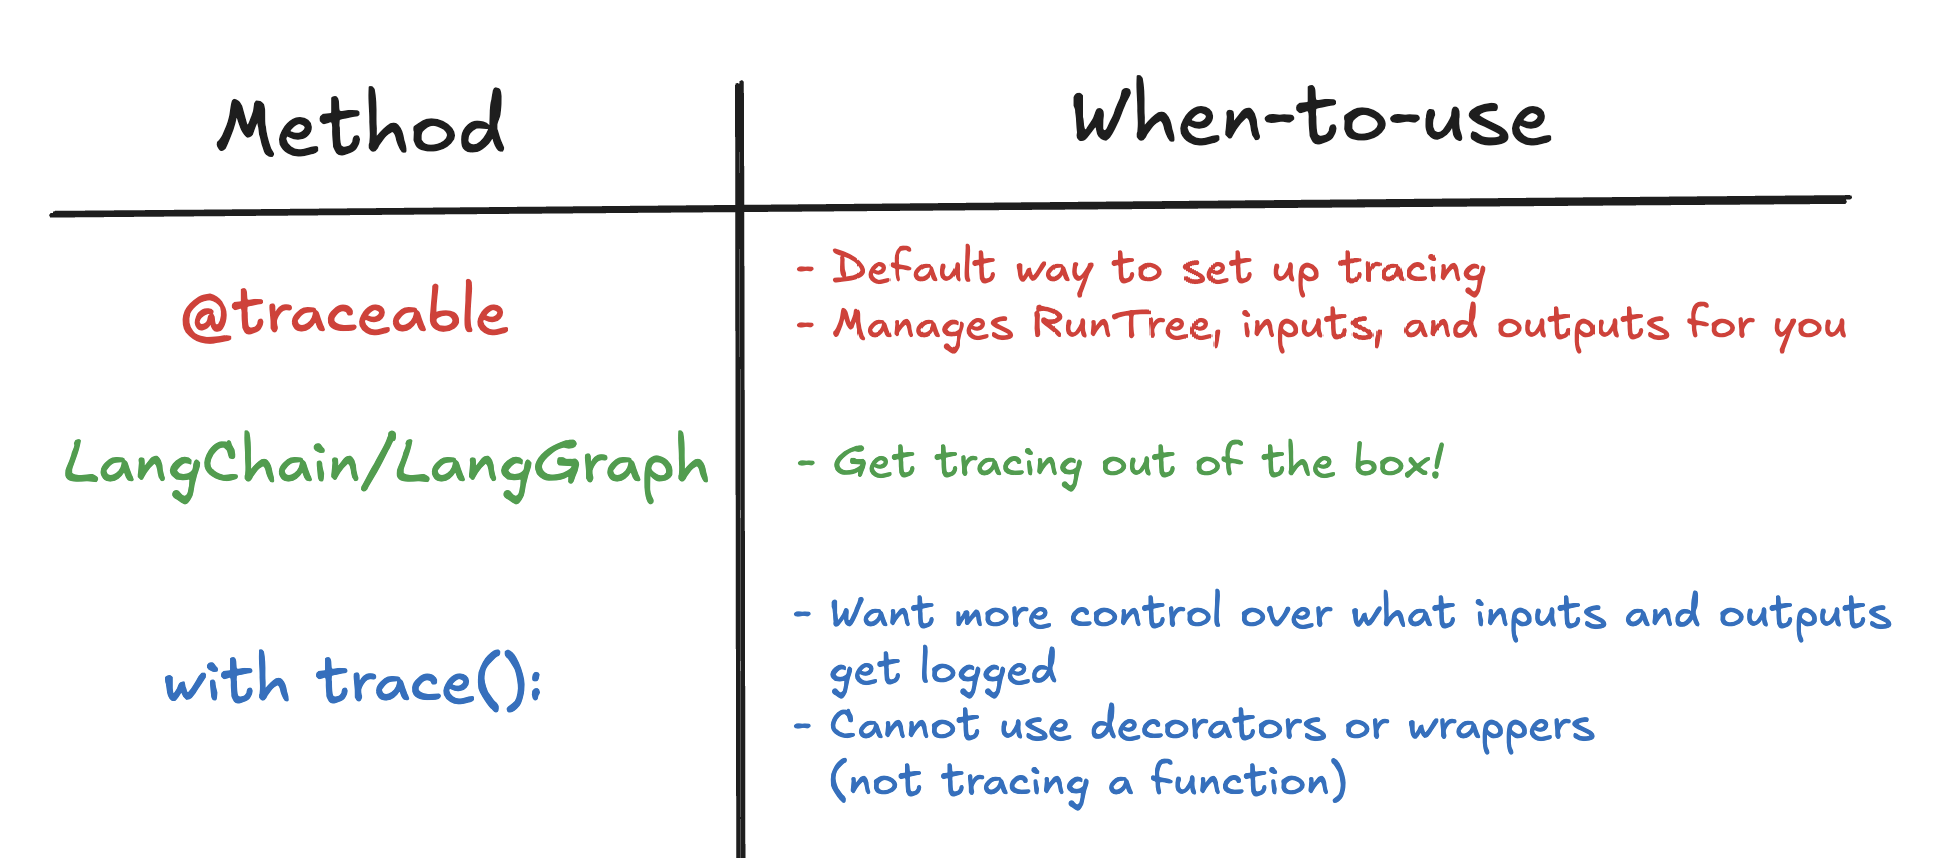

In [4]:
from langsmith import traceable, trace
from openai import OpenAI
from typing import List
import nest_asyncio
from utils import get_vector_db_retriever

MODEL_PROVIDER = "openai"
MODEL_NAME = "gpt-4o-mini"
APP_VERSION = 1.0
RAG_SYSTEM_PROMPT = """You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the latest question in the conversation. 
If you don't know the answer, just say that you don't know. 
Use three sentences maximum and keep the answer concise.
"""

openai_client = OpenAI()
nest_asyncio.apply()
retriever = get_vector_db_retriever()

"""
retrieve_documents
- Returns documents fetched from a vectorstore based on the user's question
"""
@traceable
def retrieve_documents(question: str):
    documents = retriever.invoke(question)
    return documents

"""
generate_response
- Calls `call_openai` to generate a model response after formatting inputs
"""
# Removed traceable, and use with trace()

def generate_response(question: str, documents):
    # NOTE: Our documents came in as a list of objects, but we just want to log a string
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)

    # using with trace()
    with trace(
         name="Generate Response",
         run_type="chain", 
         inputs={"question": question, "formatted_docs": formatted_docs},
         metadata={"foo": "bar"},
     ) as ls_trace:
        messages = [
            {
                "role": "system",
                "content": RAG_SYSTEM_PROMPT
            },
            {
                "role": "user",
                "content": f"Context: {formatted_docs} \n\n Question: {question}"
            }
        ]
        response = call_openai(messages)
        # ended the trace and write outputs to LangSmith
        ls_trace.end(outputs={"output": response})
        #this will log the response and end the trace
    return response

"""
call_openai
- Returns the chat completion output from OpenAI
"""
@traceable
def call_openai(
    messages: List[dict], model: str = MODEL_NAME, temperature: float = 0.0
) -> str:
    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
    )
    return response

"""
langsmith_rag
- Calls `retrieve_documents` to fetch documents
- Calls `generate_response` to generate a response based on the fetched documents
- Returns the model response
"""
@traceable
def langsmith_rag(question: str):
    documents = retrieve_documents(question)
    response = generate_response(question, documents)
    return response.choices[0].message.content

In [7]:
question = "Give me a brief of how politics work in India and the public general feedback about it"
ai_answer = langsmith_rag(question)
#asking q out of the documents to check retrival 
print(ai_answer)

I don't know.


### wrap_openai
The wrap_openai/wrapOpenAI methods in Python/TypeScript allow you to wrap your OpenAI client in order to automatically log traces -- no decorator or function wrapping required! The wrapper works seamlessly with the @traceable decorator or traceable function and you can use both in the same application.

You still need to set your LANGSMITH_API_KEY and LANGSMITH_TRACING


In [ ]:
# imported wrap_openai
from langsmith.wrappers import wrap_openai
import openai
from typing import List
import nest_asyncio
from utils import get_vector_db_retriever

MODEL_PROVIDER = "openai"
MODEL_NAME = "gpt-4o-mini"
APP_VERSION = 1.0
RAG_SYSTEM_PROMPT = """You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the latest question in the conversation. 
If you don't know the answer, just say that you don't know. 
Use three sentences maximum and keep the answer concise.
"""

# wrapped the OpenAI Client
openai_client = wrap_openai(openai.Client())

nest_asyncio.apply()
retriever = get_vector_db_retriever()

@traceable(run_type="chain")
def retrieve_documents(question: str):
    return retriever.invoke(question)

@traceable(run_type="chain")
def generate_response(question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    messages = [
        {
            "role": "system",
            "content": RAG_SYSTEM_PROMPT
        },
        {
            "role": "user",
            "content": f"Context: {formatted_docs} \n\n Question: {question}"
        }
    ]
    # We don't need to use @traceable on a nested function call anymore,
    # wrap_openai takes care of this for us
    return openai_client.chat.completions.create(
        model=MODEL_NAME,
        messages=messages,
    )

@traceable(run_type="chain")
def langsmith_rag_with_wrap_openai(question: str):
    documents = retrieve_documents(question)
    response = generate_response(question, documents)
    return response.choices[0].message.content

In [ ]:
question = "How do I trace with wrap_openai? What are the steps different from using trace?"
ai_answer = langsmith_rag_with_wrap_openai(question)
print(ai_answer)

To trace with `wrap_openai`, you need to ensure that the `LANGSMITH_TRACING` environment variable is set to 'true' and provide your LangSmith API key through the `LANGSMITH_API_KEY` environment variable. Unlike using the standard `@traceable` decorator, `wrap_openai` automatically logs traces without needing decorators or function wrapping, providing a smoother integration. Additionally, you may need to specify the workspace ID with `LANGSMITH_WORKSPACE_ID` if your API key is linked to multiple workspaces.


In [10]:
messages = [
    {
        "role": "user",
        "content": "What type of soil is the best for growth of plants and where is it abundantly found on earth? Also state reasons for your answer"
    }
]

openai_client.chat.completions.create(
    model=MODEL_NAME,
    messages=messages,
    langsmith_extra={"metadata": {"foo": "bar"}},
)

ChatCompletion(id='chatcmpl-CMu4SlhJh5vdtyqoFOsDV9iiFooXn', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='The best type of soil for plant growth is typically **loamy soil**. Loamy soil is a balanced mix of sand, silt, and clay, making it ideal for a variety of plants. Here are some reasons why loamy soil is considered the best for plant growth:\n\n### Characteristics of Loamy Soil:\n1. **Texture**: Loamy soil has a balanced texture that provides a good structure for roots to grow. The combination of sand (for drainage), silt (for nutrients), and clay (for water retention) creates an ideal environment for plants.\n\n2. **Nutrient-Rich**: Loamy soils tend to be rich in organic matter and essential nutrients that are vital for plant growth. This organic content improves soil fertility, promoting healthy plant development.\n\n3. **Water Retention and Drainage**: Loamy soil has good water-holding capacity while also allowing excess wate

### (advanced) RunTree
The RunTree API gives explicit control over tracing - can manually create runs and child runs to build your trace. Requires LANGSMITH_API_KEY only, but LANGSMITH_TRACING not needed.



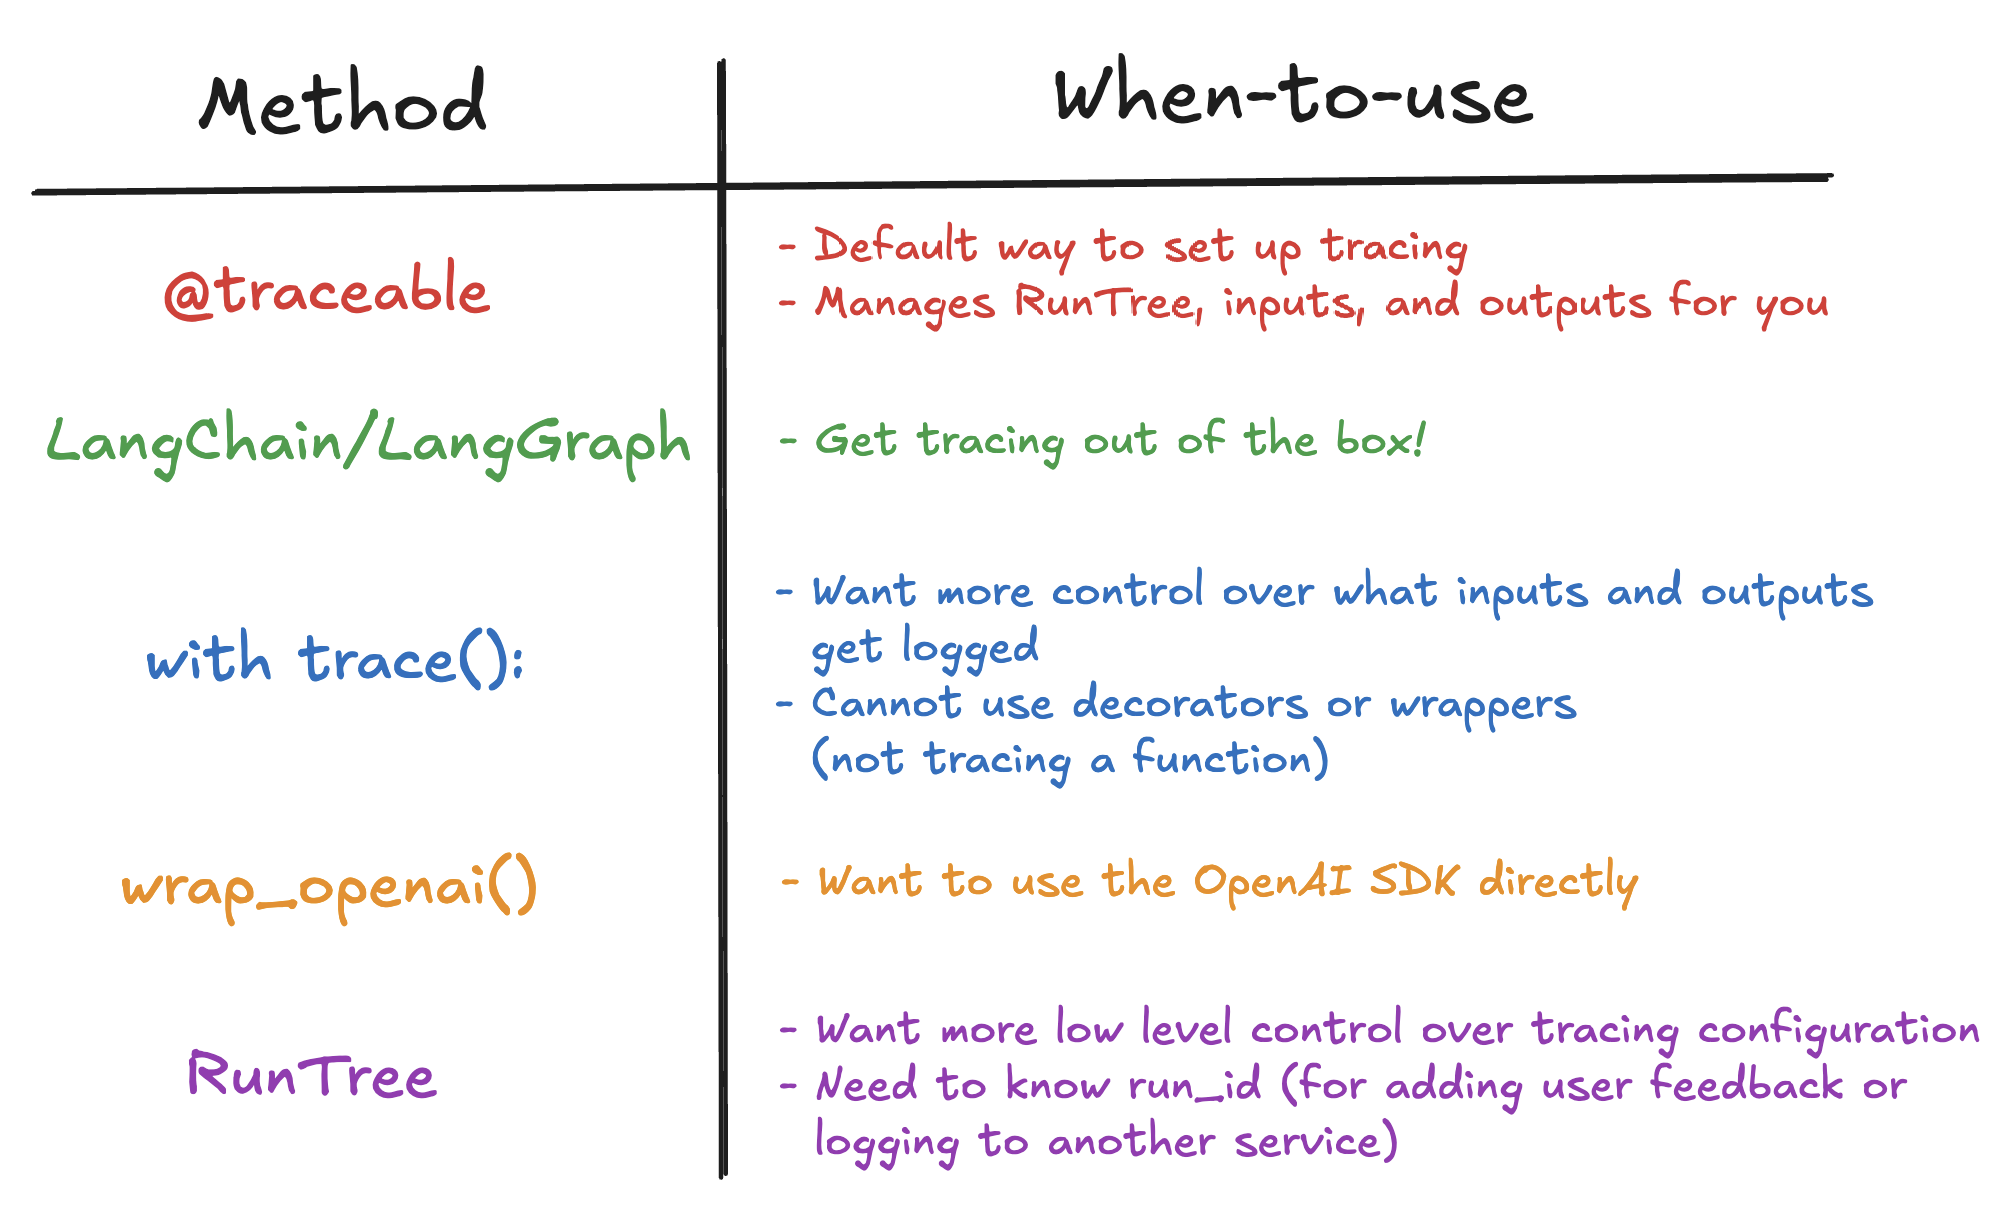

In [ ]:
from dotenv import load_dotenv
load_dotenv()

In [ ]:
import os
os.environ["LANGSMITH_TRACING"] = "false"

from langsmith import utils
utils.tracing_is_enabled() # This should return false

We have rewritten our RAG application, except this time we pass a RunTree argument through our function calls, and create child runs at each layer. This gives our RunTree the same hierarchy that we were automatically able to establish with @traceable

In [11]:
from langsmith import RunTree
from openai import OpenAI
from typing import List
import nest_asyncio
from utils import get_vector_db_retriever

openai_client = OpenAI()
nest_asyncio.apply()
retriever = get_vector_db_retriever()

def retrieve_documents(parent_run: RunTree, question: str):
    # Create a child run
    child_run = parent_run.create_child(
        name="Retrieve Documents",
        run_type="retriever",
        inputs={"question": question},
    )
    documents = retriever.invoke(question)
    # Post the output of our child run
    child_run.end(outputs={"documents": documents})
    child_run.post()
    return documents

def generate_response(parent_run: RunTree, question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    rag_system_prompt = """You are an assistant for question-answering tasks. 
    Use the following pieces of retrieved context to answer the latest question in the conversation. 
    If you don't know the answer, just say that you don't know. 
    Use three sentences maximum and keep the answer concise.
    """
    # Create a child run
    child_run = parent_run.create_child(
        name="Generate Response",
        run_type="chain",
        inputs={"question": question, "documents": documents},
    )
    messages = [
        {
            "role": "system",
            "content": rag_system_prompt
        },
        {
            "role": "user",
            "content": f"Context: {formatted_docs} \n\n Question: {question}"
        }
    ]
    openai_response = call_openai(child_run, messages)
    # Post the output of our child run
    child_run.end(outputs={"openai_response": openai_response})
    child_run.post()
    return openai_response

def call_openai(
    parent_run: RunTree, messages: List[dict], model: str = "gpt-4o-mini", temperature: float = 0.0
) -> str:
    # Create a child run
    child_run = parent_run.create_child(
        name="OpenAI Call",
        run_type="llm",
        inputs={"messages": messages},
    )
    openai_response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
    )
    # Post the output of our child run
    child_run.end(outputs={"openai_response": openai_response})
    child_run.post()
    return openai_response

def langsmith_rag(question: str):
    # Create a root RunTree
    root_run_tree = RunTree(
        name="Chat Pipeline",
        run_type="chain",
        inputs={"question": question}
    )

    # Pass our RunTree into the nested function calls
    documents = retrieve_documents(root_run_tree, question)
    response = generate_response(root_run_tree, question, documents)
    output = response.choices[0].message.content

    # Post our final output
    root_run_tree.end(outputs={"generation": output})
    root_run_tree.post()
    return output
    

In [12]:
question = "How can I trace with RunTree?"
ai_answer = langsmith_rag(question)
print(ai_answer)

To trace with RunTree, you can use the `RunTree.fromHeaders` method to create a run tree from the request headers. Then, utilize the `withRunTree` helper to ensure the run tree is propagated within traceable invocations. This allows you to maintain the context of the trace throughout your application's operations.
